In [ ]:
# The purpose of this project is to do PCA and generate a tSNE plot

In [1]:
# do imports
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps
import pickle
import pandas as pd
import seaborn as sns

In [9]:
#extract shoot and root data from csv files
reads = np.empty((22383, 166))
OTUs = np.empty(22383, dtype=str)
plate = np.empty(166, dtype=str)
OTU = []
f = open('figure2A_raw.csv', 'r')
i = 0
# Parsing the data
for line in f:
    line = line.strip()
    line = line.split(',')
    if line[0] == '""':
        for j in range(len(line)):
            line[j] = line[j][1:-1]
        plate = line[1::] # Save plates
    else:
        reads[i] = line[1::]
        if line[0][1] == 'A':
            line[0] = line[0][1:-1]
            OTU.append(line[0]) # Save ASVs
        i += 1
OTUs = OTU

# Initialize index lists
root_ind = []
shoot_ind = []
soil_ind = []
q = open('data_Fig2A_S2A.csv', 'r') # This has the metadata, ie part of the plant
for row in q:
    row = row.strip()
    row = row.split(',')
    pos = row[0]+'_'+row[1]
    #if row[6] == 'Col-0': # From Figure 2A analysis
    # Saving indices for sites
    if row[8] == 'Root':
        root_ind.append(plate.index(pos))
    if row[8] == 'Soil':
        soil_ind.append(plate.index(pos))
    if row[8] == 'Shoot':
        shoot_ind.append(plate.index(pos))

In [3]:
plate_2 = []
q = open('data_Fig2A_S2a.csv', 'r')
for row in q:
    row = row.strip()
    row = row.split(',')
    plate_2.append(row[0] +'_'+ row[1])
plate_2 = plate_2[1::]

extras = []
for i in plate:
    if i not in plate_2:
        extras.append(plate.index(i))

In [10]:
reads = np.delete(reads, extras, axis=1)
print(reads.shape)

(22383, 159)


In [11]:
#rarefy the data
# Do imports
from numpy.random import RandomState 

def rarefaction(M, seed=0):
    '''Rarefies an array M. Allows seed to be set for reproducible results.'''
    prng = RandomState(seed) # reproducible results
    noccur = np.sum(M, axis=0) # number of occurrences for each sample
    nvar = M.shape[0] # number of variables
    depth = 3000

    Mrarefied = np.empty_like(M)
    for i in range(M.shape[1]): # for each sample
        p = M[:,i] / float(noccur[i]) # relative frequency / probability
        choice = prng.choice(nvar, depth, p=p)
        Mrarefied[:,i] = np.bincount(choice, minlength=nvar)

    return Mrarefied

In [12]:
# Rarefy data
rare = rarefaction(reads, seed=130816)
print(rare.shape)

(22383, 159)


In [14]:
# Calculate bray-curtis dissimilarities
from scipy.spatial import distance

result = np.zeros((rare.shape[1], rare.shape[1]))

for i in range(rare.shape[1]):
    for j in range(rare.shape[1]):
        result[i,j] = distance.braycurtis(rare[:,i], rare[:,j])
    

In [15]:
print(result[0])
# Bray-Curtis dissimilarities look good

[0.         0.906      0.984      0.773      0.97733333 0.93066667
 0.94166667 0.967      0.75566667 0.73533333 0.558      0.86966667
 0.70966667 0.92933333 0.86533333 0.85066667 0.85533333 0.73733333
 0.95433333 0.74133333 0.853      0.65166667 0.93233333 0.64033333
 0.873      0.675      0.94933333 0.95966667 0.98366667 0.87466667
 0.72933333 0.93733333 0.82966667 0.93233333 0.96833333 0.96966667
 0.92066667 0.938      0.785      0.84033333 0.94633333 0.86433333
 0.93233333 0.93633333 0.89366667 0.66533333 0.93733333 0.94933333
 0.88333333 0.968      0.625      0.869      0.97233333 0.85633333
 0.88133333 0.763      0.977      0.82466667 0.932      0.867
 0.947      0.944      0.73566667 0.93566667 0.964      0.71633333
 0.794      0.90733333 0.972      0.73166667 0.93966667 0.933
 0.89766667 0.92566667 0.927      0.969      0.974      0.71666667
 0.98066667 0.60533333 0.983      0.68866667 0.934      0.886
 0.71766667 0.96866667 0.67466667 0.89666667 0.959      0.97333333
 0.892    

In [21]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(rare)
print('Variance Explained: ', pca.explained_variance_ratio_)

Variance Explained:  [0.24148596 0.15631404]


In [49]:
# PCA imports
from sklearn.decomposition import PCA
# finding principle components
pca = PCA(n_components = 3) # this defines the model
pca.fit(result) # this fits the model
# a good measure of performance
#print('Variance Explained: ', pca.explained_variance_ratio_)

PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [22]:
# Make target variable to label sites as 0, 1 and 2
#target = np.zeros(result.shape[1])
#for i in range(site_ind.size-1):
    #target[site_ind[i]:site_ind[i+1]] = i
target = np.zeros((159))
for i in range(target.size):
    if i in root_ind:
        target[i] = 0
    if i in soil_ind:
        target[i] = 1
    if i in shoot_ind:
        target[i] = 2
print(len(target))

159


In [59]:
# PCA imports
from sklearn.decomposition import PCA
# finding principle components
pca = PCA(n_components = 5) # this defines the model
pca.fit(result) # this fits the model
# a good measure of performance
print('Variance Explained: ', pca.explained_variance_ratio_)

Variance Explained:  [0.32931303 0.16882116 0.13735137 0.0659648  0.03862332]


In [62]:
# t-SNE imports
from sklearn.manifold import TSNE
# finding principle components
tsne = TSNE(n_components=2)
tsne.fit(result)
#print('Variance Explained: ', tsne.explained_variance_ratio_)

TSNE(angle=0.5, early_exaggeration=12.0, init='random', learning_rate=200.0,
   method='barnes_hut', metric='euclidean', min_grad_norm=1e-07,
   n_components=2, n_iter=1000, n_iter_without_progress=300,
   perplexity=30.0, random_state=None, verbose=0)

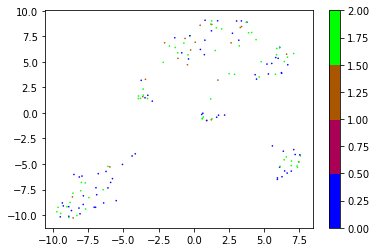

In [63]:
# t-SNE vizualization
X_tsne = tsne.fit_transform(result)
plt.scatter(X_tsne[:,0], X_tsne[:,1], c = target, s =0.4, cmap=plt.cm.get_cmap('brg',4))
plt.colorbar();
# The non-linear transformation is evident in the shapes and the fact
# that the brown cluster is detached from red and green clusters.